In [14]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from dateutil.relativedelta import relativedelta

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=4)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option("display.max_columns", None)
plt.style.use('seaborn')
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = 'IPAexGothic'

# Ch.04 顧客の行動を予測する

スポーツジムの会員データを使って顧客の行動を分析する。  
３章で顧客の全体像を把握した。  
ここからは、機械学習を用いて顧客のグループ化や顧客の利用予測行なっていく。  
ここでは、教師なし学習、教師あり学習の回帰を取り扱う。

データ概要

- use_log.csv
  - ジムの利用履歴データ
  - 2018-04~2019-03
- customer_master.csv
  - 2019-03末時点の会員データ
- class_master.csv
  - 会員区分データ（オールタイム・デイタイム・ナイト）
- campaign_master.csv
  - キャンペーン区分データ（入会無料等）
- customer_join.csv
  - Ch.03で作成した利用履歴を含んだ顧客データ

### Knock31: データの読み込み

- 「use_log.csv」と「customer_join.csv」を読み込む

In [2]:
# 「use_log.csv」を読み込む

uselog = pd.read_csv("../support/4章/use_log.csv")
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [3]:
# 「customer_join.csv」を読み込む

customer = pd.read_csv("../support/4章/customer_join.csv")
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

### Knock32: クラスタリングで顧客をグループ化する

In [8]:
# クラスタリングに用いる変数
# customer["mean", "median", "max", "min", "membership_period"]

customer_clustering = customer[["mean", "median", "max", "min", "membership_period"]]
print(customer_clustering.shape)
display(customer_clustering)

(4192, 5)


,mean,median,max,min,membership_period
0,4.8333,5.0000,8,2,47
1,5.0833,5.0000,7,3,47
2,4.5833,5.0000,6,3,47
3,4.8333,4.5000,7,2,47
4,3.9167,4.0000,6,1,47
...,...,...,...,...,...
4187,8.0000,8.0000,8,8,1
4188,10.0000,10.0000,10,10,1
4189,8.0000,8.0000,8,8,1
4190,11.0000,11.0000,11,11,1


In [9]:
# K-means法
# 変数化の距離をベースにグループ化する
# 4つのグループに分ける

# 標準化
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

# Kmeansモデル構築
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering = customer_clustering.assign(cluster=clusters.labels_)

print(customer_clustering["cluster"].unique())
display(customer_clustering)

[1 2 3 0]


,mean,median,max,min,membership_period,cluster
0,4.8333,5.0000,8,2,47,1
1,5.0833,5.0000,7,3,47,1
2,4.5833,5.0000,6,3,47,1
3,4.8333,4.5000,7,2,47,1
4,3.9167,4.0000,6,1,47,1
...,...,...,...,...,...,...
4187,8.0000,8.0000,8,8,1,0
4188,10.0000,10.0000,10,10,1,0
4189,8.0000,8.0000,8,8,1,0
4190,11.0000,11.0000,11,11,1,0


### Knock33: クラスタリング結果を分析する

In [11]:
# 列名の変更
customer_clustering.columns = [
    "月内平均値", "月内中央値", "月内最大値", "月内最小値", "会員期間", "cluster"
]

display(customer_clustering)

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間,cluster
0,4.8333,5.0000,8,2,47,1
1,5.0833,5.0000,7,3,47,1
2,4.5833,5.0000,6,3,47,1
3,4.8333,4.5000,7,2,47,1
4,3.9167,4.0000,6,1,47,1
...,...,...,...,...,...,...
4187,8.0000,8.0000,8,8,1,0
4188,10.0000,10.0000,10,10,1,0
4189,8.0000,8.0000,8,8,1,0
4190,11.0000,11.0000,11,11,1,0


In [12]:
# グループごとのデータ件数

customer_clustering.groupby("cluster").count()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,840,840,840,840,840
1,1249,1249,1249,1249,1249
2,771,771,771,771,771
3,1332,1332,1332,1332,1332


In [13]:
# グループごとの平均値

customer_clustering.groupby("cluster").mean()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,8.0619,8.0470,10.0143,6.1750,7.0190
1,4.6776,4.6709,7.2338,2.1537,36.9159
2,3.0655,2.9001,4.7834,1.6498,9.2763
3,5.5395,5.3911,8.7560,2.7027,14.8679


- グループ0
  - 会員期間が短い、利用率が高い
- グループ2
  - 会員期間が短い、最も利用率が低い
- グループ1
  - 会員期間が長い
  - グループ3より利用率が低い
- グループ3
  - 会員期間が最も長い

### Knock34: クラスタリング結果を可視化する

In [16]:
# 2次元上にプロットするため、次元削除を行う
# 次元削除の手法である主成分分析を行う

X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering["cluster"]

display(pca_df)

,0,1,cluster
0,-0.8200,-1.9591,1
1,-0.7079,-1.7999,1
2,-1.0615,-1.6598,1
3,-1.1608,-1.8101,1
4,-2.0171,-1.6701,1
...,...,...,...
4187,3.0279,1.1396,0
4188,5.0647,0.7697,0
4189,3.0279,1.1396,0
4190,6.0831,0.5847,0


<Figure size 432x288 with 0 Axes>

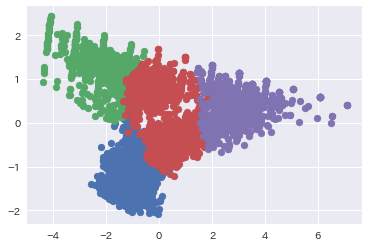

<Figure size 432x288 with 0 Axes>

In [18]:
# 次元削除による可視化

for i in customer_clustering["cluster"].unique():
    tmp = pca_df.loc[pca_df["cluster"] == i]
    plt.scatter(tmp[0], tmp[1])

### Knock35: クラスタリング結果をもとに退会ユーザーの傾向を把握する